# PART1 CODE

In [53]:
import pandas as pd 
import numpy as np
import copy

#data = pd.read_csv("train.csv") 
#ran = np.random.rand(len(data)) < 0.8
#train = data[ran]
#val = data[~ran]
#train.to_csv('UsedTrainingData.csv')
#val.to_csv('UsedValidationData.csv')

train =  pd.read_csv('UsedTrainingData.csv')
val = pd.read_csv('UsedValidationData.csv')

train = train.loc[:,['Work_accident', 'promotion_last_5years', 'sales', 'salary','left'] ] 
val = val.loc[:,['Work_accident', 'promotion_last_5years', 'sales', 'salary','left'] ] 

#train = train.drop_duplicates(subset=None, keep=False, inplace=False)
#val = val.drop_duplicates(subset=None, keep=False, inplace=False)

targetAttribute = 'left'
Attributes = list(train.columns)
Attributes.remove(targetAttribute)
examples = list(train.index.values) 

NumericalAttributes = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
CategoricalAttributes = ['Work_accident', 'promotion_last_5years', 'sales', 'salary']

def getImpurityOfExamples(examplesForCurNode,method):
    NumberOfPosEx = 0
    NumberOfNegEx = 0
    for j in examplesForCurNode:
        if  str(train.at[int(j),targetAttribute]) == str(1):
            NumberOfPosEx = NumberOfPosEx+1
        elif str(train.at[int(j),targetAttribute]) == str(0):
             NumberOfNegEx = NumberOfNegEx+1
    PropOfPos =  NumberOfPosEx/len(examplesForCurNode)
    PropOfNeg = NumberOfNegEx/len(examplesForCurNode)
    if method == 'Gini':
        return (2*PropOfPos*PropOfNeg)
    elif method == 'misClasifi':
        return min(PropOfPos,PropOfNeg)
    elif method == 'Entropy':
        if PropOfPos == 0:
            return (-1*PropOfNeg*(np.log(PropOfNeg)/np.log(2)))
        elif PropOfNeg == 0:
            return (-1*PropOfPos*(np.log(PropOfPos)/np.log(2)))
        else:
            return ((-1*PropOfPos*(np.log(PropOfPos)/np.log(2))) + (-1*PropOfNeg*(np.log(PropOfNeg)/np.log(2))))

def getMethodImpurity(Attribute,value,examplesForCurAttr,method): 
    fra1 = train.loc[examplesForCurAttr,:]
    LessThanExamples = []
    MoreThanExamples = []
    if Attribute in NumericalAttributes: 
        for j in examplesForCurAttr:
            if  float(str(fra1.at[int(j),Attribute])) <= float(str(value)):
                LessThanExamples.append(int(j))
            else:
                MoreThanExamples.append(int(j))
    else:
        for j in examplesForCurAttr:
            if  str(fra1.at[int(j),Attribute]) == str(value):
                LessThanExamples.append(int(j))
            else:
                MoreThanExamples.append(int(j))
        if len(MoreThanExamples) <= 0:
            return 999
        elif len(LessThanExamples) <=0:
            return getImpurityOfExamples(MoreThanExamples,method)
        else:            
            return ((len(LessThanExamples)*getImpurityOfExamples(LessThanExamples,method))+(len(MoreThanExamples)*getImpurityOfExamples(MoreThanExamples,method)))/len(examplesForCurAttr)
    
class Node(object):
    def __init__(self,examples,decisionAttributeType,decisionAttribute,decisionAttributeValue,level):
        self.examples = examples
        self.decisionAttributeType = decisionAttributeType
        self.decisionAttribute = decisionAttribute        
        self.decisionAttributeValue = decisionAttributeValue
        self.level = level
        self.leftChild = None
        self.rightChild = None
        
    def __str__(self): 
        return "Decision attribute type is "+self.decisionAttributeType+"decisionAttribute is "+ self.decisionAttribute+" decisionAttributeValue is "+ str(self.decisionAttributeValue)+" of level "+str(self.level)+" number of examples of this node "+str(len(self.examples))
    
def BestOfAttributes(examplesForCurAttr,targetAttribute,method):
    
    fra1 = train.loc[examplesForCurAttr,CategoricalAttributes]
    dictForCategAttrUniqueValues = {}
    for i in CategoricalAttributes:
        dictForCategAttrUniqueValues[i] = list(fra1[i].sort_values().unique())
    dictForEntropyUniqueValueCateg = copy.deepcopy(dictForCategAttrUniqueValues)
    print("calculating Impurities please wait")
    for i in CategoricalAttributes:
        for j,val in enumerate(dictForCategAttrUniqueValues[i]):
            dictForEntropyUniqueValueCateg[i][j] = getMethodImpurity(i,dictForCategAttrUniqueValues[i][j],examplesForCurAttr,method)          
    EntropyValuesForCategoricalAttributes = {}
    for i in CategoricalAttributes:
        EntropyValuesForCategoricalAttributes[i]=min(dictForEntropyUniqueValueCateg[i])
    BestOfCategoricalAttributes = min(EntropyValuesForCategoricalAttributes, key=EntropyValuesForCategoricalAttributes.get)
    BestOfCategoricalAttributesValue = min(EntropyValuesForCategoricalAttributes.values())   
    
    if BestOfCategoricalAttributesValue > 1:
        return BestOfCategoricalAttributes,'No Attribute'
        
    for index, item in enumerate(dictForEntropyUniqueValueCateg[BestOfCategoricalAttributes]):
        if item == BestOfCategoricalAttributesValue:
            BestSplitValueCategorical = dictForCategAttrUniqueValues[BestOfCategoricalAttributes][index]
            break            
    return BestOfCategoricalAttributes,BestSplitValueCategorical
    
def DecisionTreeBuilder(examplesForCurNode,targetAttribute,level,method):
    allExPos = True
    for i in examplesForCurNode:
        if str(train.at[int(i),targetAttribute]) == str(1):
            pass
        else:
            allExPos = False
            break
    if allExPos:        
        r = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
        print(r)
        #print("Type1")
        return r
    allExNeg = True
    for j in examplesForCurNode:
        if str(train.at[j,targetAttribute]) == str(0):
            pass
        else:
            allExNeg = False
            break
    if allExNeg:
        r = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)
        print(r)
        #print("Type2")
        return r
    if getImpurityOfExamples(examplesForCurNode,method) < 0.001 or len(examplesForCurNode)<10:
        fra1 = train.loc[examplesForCurNode,[targetAttribute] ]
        targetAttributesList = fra1[targetAttribute].values
        unique1, counts1 = np.unique(targetAttributesList, return_counts=True)
        dictOfTaAttr = dict(zip(unique1, counts1))
        posCount = dictOfTaAttr[1]
        negCount = dictOfTaAttr[0]
        if (posCount/(posCount+negCount))>0.24:
            r = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
            #numberOfNodes  = numberOfNodes + 1
        else:
            r = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)
            #numberOfNodes  = numberOfNodes + 1
        print(r)
        #print("Type3")
        return r
    
    BestAttribute,BestAttributeValue = BestOfAttributes(examplesForCurNode,targetAttribute,method)
    
    if BestAttributeValue == 'No Attribute':
        fra1 = train.loc[examplesForCurNode,[targetAttribute] ]
        targetAttributesList = fra1[targetAttribute].values
        unique1, counts1 = np.unique(targetAttributesList, return_counts=True)
        dictOfTaAttr = dict(zip(unique1, counts1))
        posCount = dictOfTaAttr[1]
        negCount = dictOfTaAttr[0]
        if (posCount/(posCount+negCount))>0.24:
            r = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
            #numberOfNodes  = numberOfNodes + 1
        else:
            r = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)
            #numberOfNodes  = numberOfNodes + 1
        print(r)
        print("Type8")
        return r 
    
    if BestAttribute in NumericalAttributes:
        BestAttributeType = 'numerical'
    else:
        BestAttributeType = 'categorical'
    r = Node(examplesForCurNode,BestAttributeType,BestAttribute,BestAttributeValue,level)
    print(r)
    print("Type4")
    #numberOfNodes  = numberOfNodes + 1
    examplesForLeftChildOfCurrentNode = []
    examplesForRightChildOfCurrentNode = []        
    if BestAttributeType == 'categorical':        
        for iter1 in examplesForCurNode:
            if  str(train.at[int(iter1),str(BestAttribute)]) == str(BestAttributeValue):
                examplesForLeftChildOfCurrentNode.append(int(iter1))
            else:
                examplesForRightChildOfCurrentNode.append(int(iter1))
    else:
        for iter1 in examplesForCurNode:
            if  float(str(train.at[int(iter1),str(BestAttribute)])) <= float(str(BestAttributeValue)):
                examplesForLeftChildOfCurrentNode.append(int(iter1))
            else:
                examplesForRightChildOfCurrentNode.append(int(iter1))
    fra1 = train.loc[examplesForCurNode,[targetAttribute] ]
    targetAttributesList = fra1[targetAttribute].values
    unique1, counts1 = np.unique(targetAttributesList, return_counts=True)
    dictOfTaAttr = dict(zip(unique1, counts1))
    posCount = dictOfTaAttr[1]
    negCount = dictOfTaAttr[0]
    if len(examplesForLeftChildOfCurrentNode)!=0:
        r.leftChild = DecisionTreeBuilder(examplesForLeftChildOfCurrentNode,targetAttribute,level+1,method)
    else:
        if (posCount/(posCount+negCount))>0.24:
            r.leftChild = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
        else:
            r.leftChild = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)
    
    if len(examplesForRightChildOfCurrentNode)!=0:
        r.rightChild = DecisionTreeBuilder(examplesForRightChildOfCurrentNode,targetAttribute,level+1,method)
    else:
        if (posCount/(posCount+negCount))>0.24:
            r.rightChild = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
        else:
            r.rightChild = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)          
   
    return r 
def CalulatePrecsionRecallEtc(GivenTestData):
    GivenTestData['predict']= [0]*len(GivenTestData)
    for i in list(GivenTestData.index.values):        
        GivenTestData.at[i,'predict'] = RecursiveFunctionToPredict(i,RootNode,GivenTestData)

    TN = 0
    FP = 0
    FN = 0
    TP = 0
    for i in list(GivenTestData.index.values):
        if str(GivenTestData.at[i,'left']) == str(1) and str(GivenTestData.at[i,'predict']) == str(1):
            TP = TP + 1
        elif str(GivenTestData.at[i,'left']) == str(1) and str(GivenTestData.at[i,'predict']) == str(0):
            FN = FN + 1
        elif str(GivenTestData.at[i,'left']) == str(0) and str(GivenTestData.at[i,'predict']) == str(1):
            FP = FP + 1
        elif str(GivenTestData.at[i,'left']) == str(0) and str(GivenTestData.at[i,'predict']) == str(0):
            TN = TN + 1
    print("Results On GivenTestData")
    print("-------------------------------------------------")
    print("True Positive are    "+ str(TP))
    print("True Negatives are   "+ str(TN))
    print("False Positive are   "+ str(FP))
    print("False Negatives are  "+str(FN))

    Precision = (TP/(TP+FP))
    Recall = (TP/(TP+FN))
    F1_Score = 2*((1/Recall)+(1/Precision))
    accuracy = (TN+TP)/(TN+TP+FP+FN)
    print("Precsion is          "+str(Precision))
    print("Recall is            "+str(Recall))
    print("F1_Score is          "+str(F1_Score))
    print("Accuracy is          "+str(accuracy))
    print("-------------------------------------------------")
    print("( Here 1's  are positive 0's are negative)")

    return GivenTestData


def RecursiveFunctionToPredict(i,r,TestSet):
    if r.decisionAttribute == 'leafNode':
        if r.decisionAttributeValue == 'Positive':
            return '1'
        else:
            return '0'
    else:
        if r.decisionAttributeType == 'categorical':            
            AttrValue = str(TestSet.at[int(i),str(r.decisionAttribute)])            
            if AttrValue == str(r.decisionAttributeValue):
                return RecursiveFunctionToPredict(i,r.leftChild,TestSet)
            else:
                return RecursiveFunctionToPredict(i,r.rightChild,TestSet)            
        elif r.decisionAttributeType == 'numerical':            
            AttrValue = float(str(TestSet.at[int(i),str(r.decisionAttribute)]))            
            if AttrValue <= float(str(r.decisionAttributeValue)):
                return RecursiveFunctionToPredict(i,r.leftChild,TestSet)
            else:
                return RecursiveFunctionToPredict(i,r.rightChild,TestSet)

def predict(RootNode,NameOfTestFile):
    GivenTestData = pd.read_csv(str(NameOfTestFile))
    GivenTestData['predict']= [0]*len(GivenTestData)
    for i in list(GivenTestData.index.values):        
        GivenTestData.at[i,'predict'] = RecursiveFunctionToPredict(i,RootNode,GivenTestData)
    
    return GivenTestData            


examplesForRootNode = examples[:]
method = 'Entropy'

RootNode = DecisionTreeBuilder(examplesForRootNode,targetAttribute,0,method)

Prediction = predict(RootNode,'sample_test.csv')


calculating Impurities please wait
Decision attribute type is categoricaldecisionAttribute is sales decisionAttributeValue is sales of level 0 number of examples of this node 22
Type4
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Positive of level 1 number of examples of this node 3
calculating Impurities please wait
Decision attribute type is categoricaldecisionAttribute is promotion_last_5years decisionAttributeValue is 0 of level 1 number of examples of this node 19
Type4
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Positive of level 2 number of examples of this node 6
calculating Impurities please wait
Decision attribute type is categoricaldecisionAttribute is sales decisionAttributeValue is IT of level 2 number of examples of this node 13
Type4
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Positive of level 3 number of examples of this node 2
calc

,Work_accident,promotion_last_5years,sales,salary,left,predict
0,0,0,sales,low,0,1
1,0,0,marketing,medium,0,1
2,0,0,IT,medium,0,1
3,0,0,product_mng,low,0,1
4,1,0,IT,low,0,1
5,0,0,marketing,low,0,1
6,0,0,IT,low,0,1
7,0,1,hr,medium,0,0
8,0,0,marketing,medium,0,1
9,0,0,sales,low,0,1


# PART1 REPORT

# PART2 CODE

In [55]:
import pandas as pd 
import numpy as np
import copy

#data = pd.read_csv("train.csv") 
#ran = np.random.rand(len(data)) < 0.8
#train = data[ran]
#val = data[~ran]
#train.to_csv('UsedTrainingData.csv')
#val.to_csv('UsedValidationData.csv')

train =  pd.read_csv('UsedTrainingData.csv')
val = pd.read_csv('UsedValidationData.csv')

targetAttribute = 'left'
Attributes = list(train.columns)
Attributes.remove(targetAttribute)
examples = list(train.index.values) 

NumericalAttributes = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
CategoricalAttributes = ['Work_accident', 'promotion_last_5years', 'sales', 'salary']

def getImpurityOfExamples(examplesForCurNode,method):
    NumberOfPosEx = 0
    NumberOfNegEx = 0
    for j in examplesForCurNode:
        if  str(train.at[int(j),targetAttribute]) == str(1):
            NumberOfPosEx = NumberOfPosEx+1
        elif str(train.at[int(j),targetAttribute]) == str(0):
             NumberOfNegEx = NumberOfNegEx+1
    PropOfPos =  NumberOfPosEx/len(examplesForCurNode)
    PropOfNeg = NumberOfNegEx/len(examplesForCurNode)
    if method == 'Gini':
        return (2*PropOfPos*PropOfNeg)
    elif method == 'misClasifi':
        return min(PropOfPos,PropOfNeg)
    elif method == 'Entropy':
        if PropOfPos == 0:
            return (-1*PropOfNeg*(np.log(PropOfNeg)/np.log(2)))
        elif PropOfNeg == 0:
            return (-1*PropOfPos*(np.log(PropOfPos)/np.log(2)))
        else:
            return ((-1*PropOfPos*(np.log(PropOfPos)/np.log(2))) + (-1*PropOfNeg*(np.log(PropOfNeg)/np.log(2))))

def getMethodImpurity(Attribute,value,examplesForCurAttr,method): 
    fra1 = train.loc[examplesForCurAttr,:]
    LessThanExamples = []
    MoreThanExamples = []
    if Attribute in NumericalAttributes: 
        for j in examplesForCurAttr:
            if  float(str(fra1.at[int(j),Attribute])) <= float(str(value)):
                LessThanExamples.append(int(j))
            else:
                MoreThanExamples.append(int(j))
    else:
        for j in examplesForCurAttr:
            if  str(fra1.at[int(j),Attribute]) == str(value):
                LessThanExamples.append(int(j))
            else:
                MoreThanExamples.append(int(j))
        
    if len(LessThanExamples) <=0 or len(MoreThanExamples) <= 0:    
        return 999
    else:  
        return ((len(LessThanExamples)*getImpurityOfExamples(LessThanExamples,method))+(len(MoreThanExamples)*getImpurityOfExamples(MoreThanExamples,method)))/len(examplesForCurAttr)
    
class Node(object):
    def __init__(self,examples,decisionAttributeType,decisionAttribute,decisionAttributeValue,level):
        self.examples = examples
        self.decisionAttributeType = decisionAttributeType
        self.decisionAttribute = decisionAttribute        
        self.decisionAttributeValue = decisionAttributeValue
        self.level = level
        self.leftChild = None
        self.rightChild = None
        
    def __str__(self): 
        return "Decision attribute type is "+self.decisionAttributeType+"decisionAttribute is "+ self.decisionAttribute+" decisionAttributeValue is "+ str(self.decisionAttributeValue)+" of level "+str(self.level)+" number of examples of this node "+str(len(self.examples))
    
def BestOfAttributes(examplesForCurAttr,targetAttribute,method):
    fra1 = train.loc[examplesForCurAttr,CategoricalAttributes]
    dictForCategAttrUniqueValues = {}
    for i in CategoricalAttributes:
        dictForCategAttrUniqueValues[i] = list(fra1[i].sort_values().unique())
    dictForEntropyUniqueValueCateg = copy.deepcopy(dictForCategAttrUniqueValues)
    print("calculating Impurities please wait")
    for i in CategoricalAttributes:
        for j,val in enumerate(dictForCategAttrUniqueValues[i]):
            dictForEntropyUniqueValueCateg[i][j] = getMethodImpurity(i,dictForCategAttrUniqueValues[i][j],examplesForCurAttr,method)          
    EntropyValuesForCategoricalAttributes = {}
    for i in CategoricalAttributes:
        EntropyValuesForCategoricalAttributes[i]=min(dictForEntropyUniqueValueCateg[i])
    BestOfCategoricalAttributes = min(EntropyValuesForCategoricalAttributes, key=EntropyValuesForCategoricalAttributes.get)
    BestOfCategoricalAttributesValue = min(EntropyValuesForCategoricalAttributes.values())   
    
    fra1 = train.loc[examplesForCurAttr,NumericalAttributes]
    dictForNumAttrUniqueValues = {}
    for i in NumericalAttributes:
        dictForNumAttrUniqueValues[i] = list(fra1[i].sort_values().unique())
    dictForEntropyUniqueValueNum = copy.deepcopy(dictForNumAttrUniqueValues)
    
    print("calculating Impurities please wait")
    for i in NumericalAttributes:
        for j,val in enumerate(dictForNumAttrUniqueValues[i]):
            dictForEntropyUniqueValueNum[i][j] = getMethodImpurity(i,dictForNumAttrUniqueValues[i][j],examplesForCurAttr,method)          
    EntropyValuesForNumericalAttributes = {}
    for i in NumericalAttributes:
        EntropyValuesForNumericalAttributes[i]=min(dictForEntropyUniqueValueNum[i])
    BestOfNumericalAttributes = min(EntropyValuesForNumericalAttributes, key=EntropyValuesForNumericalAttributes.get)
    BestOfNumericalAttributesValue = min(EntropyValuesForNumericalAttributes.values())
    
    for index, item in enumerate(dictForEntropyUniqueValueNum[BestOfNumericalAttributes]):
        if item == BestOfNumericalAttributesValue:
            BestSplitValueNumerical = dictForNumAttrUniqueValues[BestOfNumericalAttributes][index]
            break
            
    for index, item in enumerate(dictForEntropyUniqueValueCateg[BestOfCategoricalAttributes]):
        if item == BestOfCategoricalAttributesValue:
            BestSplitValueCategorical = dictForCategAttrUniqueValues[BestOfCategoricalAttributes][index]
            break

    if BestOfNumericalAttributesValue < BestOfCategoricalAttributesValue:
        return BestOfNumericalAttributes,BestSplitValueNumerical
    else: 
        return BestOfCategoricalAttributes,BestSplitValueCategorical
numberOfNodes = 0    
def DecisionTreeBuilder(examplesForCurNode,targetAttribute,level,method,levelLimit):
    global numberOfNodes
    allExPos = True
    for i in examplesForCurNode:
        if str(train.at[int(i),targetAttribute]) == str(1):
            pass
        else:
            allExPos = False
            break
    if allExPos:        
        r = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
        print(r)
        numberOfNodes  = numberOfNodes + 1
        #print("Type1")
        return r
    allExNeg = True
    for j in examplesForCurNode:
        if str(train.at[j,targetAttribute]) == str(0):
            pass
        else:
            allExNeg = False
            break
    if allExNeg:
        r = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)
        print(r)
        numberOfNodes  = numberOfNodes + 1
        #print("Type2")
        return r
    if getImpurityOfExamples(examplesForCurNode,method) < 0.01 or len(examplesForCurNode)<50 or level >= levelLimit: #or numberOfNodes > nodeLimit:
        fra1 = train.loc[examplesForCurNode,[targetAttribute] ]
        targetAttributesList = fra1[targetAttribute].values
        unique1, counts1 = np.unique(targetAttributesList, return_counts=True)
        dictOfTaAttr = dict(zip(unique1, counts1))
        posCount = dictOfTaAttr[1]
        negCount = dictOfTaAttr[0]
        if (posCount/(posCount+negCount))>0.5:
            r = Node(examplesForCurNode,'leafNode','leafNode','Positive',level)
            numberOfNodes  = numberOfNodes + 1
        else:
            r = Node(examplesForCurNode,'leafNode','leafNode','Negative',level)
            numberOfNodes  = numberOfNodes + 1
        print(r)
        #print("Type3")
        return r
    
    BestAttribute,BestAttributeValue = BestOfAttributes(examplesForCurNode,targetAttribute,method)
    
    if BestAttribute in NumericalAttributes:
        BestAttributeType = 'numerical'
    else:
        BestAttributeType = 'categorical'
    r = Node(examplesForCurNode,BestAttributeType,BestAttribute,BestAttributeValue,level)
    print(r)
    #print("Type4")
    numberOfNodes  = numberOfNodes + 1
    examplesForLeftChildOfCurrentNode = []
    examplesForRightChildOfCurrentNode = []        
    if BestAttributeType == 'categorical':        
        for iter1 in examplesForCurNode:
            if  str(train.at[int(iter1),str(BestAttribute)]) == str(BestAttributeValue):
                examplesForLeftChildOfCurrentNode.append(int(iter1))
            else:
                examplesForRightChildOfCurrentNode.append(int(iter1))
    else:
        for iter1 in examplesForCurNode:
            if  float(str(train.at[int(iter1),str(BestAttribute)])) <= float(str(BestAttributeValue)):
                examplesForLeftChildOfCurrentNode.append(int(iter1))
            else:
                examplesForRightChildOfCurrentNode.append(int(iter1))
    r.leftChild = DecisionTreeBuilder(examplesForLeftChildOfCurrentNode,targetAttribute,level+1,method,levelLimit)
    r.rightChild = DecisionTreeBuilder(examplesForRightChildOfCurrentNode,targetAttribute,level+1,method,levelLimit)    
    return r 

def CalulatePrecsionRecallEtc(GivenTestData):
    GivenTestData['predict']= [0]*len(GivenTestData)
    for i in list(GivenTestData.index.values):        
        GivenTestData.at[i,'predict'] = RecursiveFunctionToPredict(i,RootNode,GivenTestData)

    TN = 0
    FP = 0
    FN = 0
    TP = 0
    for i in list(GivenTestData.index.values):
        if str(GivenTestData.at[i,'left']) == str(1) and str(GivenTestData.at[i,'predict']) == str(1):
            TP = TP + 1
        elif str(GivenTestData.at[i,'left']) == str(1) and str(GivenTestData.at[i,'predict']) == str(0):
            FN = FN + 1
        elif str(GivenTestData.at[i,'left']) == str(0) and str(GivenTestData.at[i,'predict']) == str(1):
            FP = FP + 1
        elif str(GivenTestData.at[i,'left']) == str(0) and str(GivenTestData.at[i,'predict']) == str(0):
            TN = TN + 1
    print("Results On GivenTestData")
    print("-------------------------------------------------")
    print("True Positive are    "+ str(TP))
    print("True Negatives are   "+ str(TN))
    print("False Positive are   "+ str(FP))
    print("False Negatives are  "+str(FN))

    Precision = (TP/(TP+FP))
    Recall = (TP/(TP+FN))
    F1_Score = 2*((1/Recall)+(1/Precision))
    accuracy = (TN+TP)/(TN+TP+FP+FN)
    print("Precsion is          "+str(Precision))
    print("Recall is            "+str(Recall))
    print("F1_Score is          "+str(F1_Score))
    print("Accuracy is          "+str(accuracy))
    print("-------------------------------------------------")
    print("( Here 1's  are positive 0's are negative)")

    return GivenTestData


def RecursiveFunctionToPredict(i,r,TestSet):
    if r.decisionAttribute == 'leafNode':
        if r.decisionAttributeValue == 'Positive':
            return '1'
        else:
            return '0'
    else:
        if r.decisionAttributeType == 'categorical':            
            AttrValue = str(TestSet.at[int(i),str(r.decisionAttribute)])            
            if AttrValue == str(r.decisionAttributeValue):
                return RecursiveFunctionToPredict(i,r.leftChild,TestSet)
            else:
                return RecursiveFunctionToPredict(i,r.rightChild,TestSet)            
        elif r.decisionAttributeType == 'numerical':            
            AttrValue = float(str(TestSet.at[int(i),str(r.decisionAttribute)]))            
            if AttrValue <= float(str(r.decisionAttributeValue)):
                return RecursiveFunctionToPredict(i,r.leftChild,TestSet)
            else:
                return RecursiveFunctionToPredict(i,r.rightChild,TestSet)

def predict(RootNode,NameOfTestFile):
    GivenTestData = pd.read_csv(str(NameOfTestFile))
    GivenTestData['predict']= [0]*len(GivenTestData)
    for i in list(GivenTestData.index.values):        
        GivenTestData.at[i,'predict'] = RecursiveFunctionToPredict(i,RootNode,GivenTestData)
    #CalulatePrecsionRecallEtc(GivenTestData)
    return GivenTestData            
examplesForRootNode = examples[:]
method = 'Entropy'
levelLimit = 8
RootNode = DecisionTreeBuilder(examplesForRootNode,targetAttribute,0,method,levelLimit)
Prediction = predict(RootNode,'sample_test.csv')


calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is numericaldecisionAttribute is satisfaction_level decisionAttributeValue is 0.46 of level 0 number of examples of this node 8989
calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is numericaldecisionAttribute is satisfaction_level decisionAttributeValue is 0.11 of level 1 number of examples of this node 2501
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Positive of level 2 number of examples of this node 545
calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is numericaldecisionAttribute is number_project decisionAttributeValue is 2 of level 2 number of examples of this node 1956
calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is numericaldecisionAttribute is average_montly_hours decisionAttributeValue is 161 of leve

calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is numericaldecisionAttribute is average_montly_hours decisionAttributeValue is 139 of level 7 number of examples of this node 3071
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Negative of level 8 number of examples of this node 211
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Negative of level 8 number of examples of this node 2860
calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is categoricaldecisionAttribute is sales decisionAttributeValue is hr of level 5 number of examples of this node 770
Decision attribute type is leafNodedecisionAttribute is leafNode decisionAttributeValue is Negative of level 6 number of examples of this node 33
calculating Impurities please wait
calculating Impurities please wait
Decision attribute type is categoricaldecisionAttrib

# PART2 REPORT

# PART3 REPORT

In [ ]:

Results On GivenTestData
-------------------------------------------------
True Positive are    1837
True Negatives are   6768
False Positive are   68
False Negatives are  316
Precsion is          0.9643044619422572
Recall is            0.8532280538783094
F1_Score is          4.418072945019053
Accuracy is          0.957281121370564
Error is             0.04271887862943598
-------------------------------------------------
( Here 1's  are positive 0's are negative)
numberOfNodes 105

Results On GivenTestData gini
-------------------------------------------------
True Positive are    2011
True Negatives are   6809
False Positive are   27
False Negatives are  142
Precsion is          0.9867517173699706
Recall is            0.9340455178820251
F1_Score is          4.1680755842864246
Accuracy is          0.9811992435198577
Error is             0.018800756480142396
-------------------------------------------------
( Here 1's  are positive 0's are negative)
numberOfNodes 123



# PART4 CODE

FileNotFoundError: [Errno 2] No such file or directory: 'output_data/pic1.png'

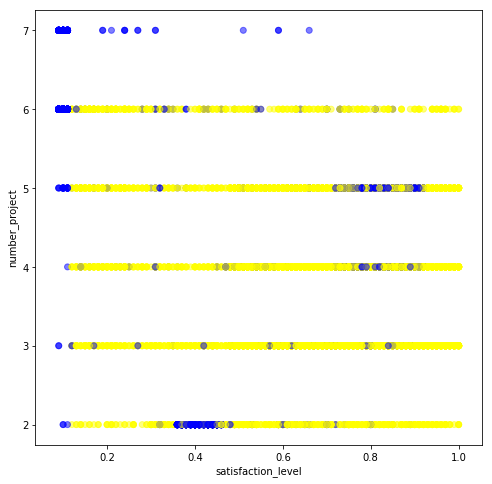

In [71]:
import pandas as pd 
import numpy as np
data = pd.read_csv("train.csv") 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
x = list(data["number_project"])
y = list(data["satisfaction_level"])
z = list(data["average_montly_hours"])
label = list(data["left"])
colors =[]
for i in range(0,len(x)):
    if label[i] == 0:
        colors.append("yellow")
    else:
        colors.append("blue")
colors1 = []
for i in range(0,len(x)):
    if label[i] == 0:
        colors1.append("red")
    else:
        colors1.append("blue")

fig = plt.figure(figsize=(8,8))
plt.scatter(y, x, color=colors,alpha = 0.5)
plt.xlabel('satisfaction_level')
plt.ylabel('number_project')
plt.savefig('output_data/pic1.png')
#plt.title('')
fig1 = plt.figure(figsize=(8,8))
plt.scatter(y, z, color=colors,alpha = 0.5)
plt.xlabel('satisfaction_level')
plt.ylabel('average_montly_hours')
#plt.scatter(y, z, color=colors1,alpha = 0.5)
#plt.savefig('../output_data/pic2.png')

#from IPython.display import Image
#Image("img/picture.png")


![alt_text](./output_data/pic1.png "Number Of Projects Vs Satisfaction Level")
![alt text](./output_data/pic2.png "Average Monthly Hours Vs Satisfaction Level")

# Part5

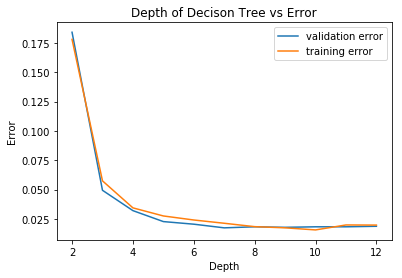

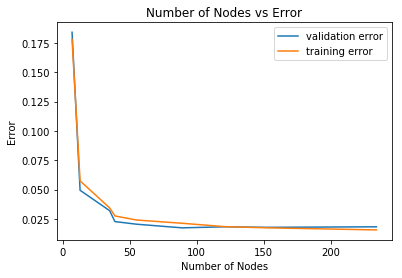

In [73]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
dictOfGraphs ={}
dictOfGraphs['depth']=[2,3,4,5,6,7,8,9,10,11,12]
dictOfGraphs['number of nodes']=[7,13,35,39,55,89,121,153,234,165,191]
dictOfGraphs['validation error']=[0.1840818141396176,0.0493552690084482,0.03201422854602046,0.02267674522009782,0.020453534904401955,0.017341040462427744,0.01823032458870609,0.017785682525566917,0.01823032458870609,0.01823032458870609,0.018674966651845263]
dictOfGraphs['training error']=[0.1779953276226499,0.05740349315830459,0.034375347647124264,0.02747802870174658,0.024029369229057736,0.021248192234953833,0.01835576816108577,0.017354544443208365,0.015574591166981866,0.019801980198019802,0.019690733118255647]

fig, ax = plt.subplots()
ax.plot(dictOfGraphs['depth'], dictOfGraphs['validation error'], label='validation error')
ax.plot(dictOfGraphs['depth'],dictOfGraphs['training error'], label='training error')
ax.legend(loc=1) # upper left corner
ax.set_xlabel('Depth')
ax.set_ylabel('Error')
ax.set_title('Depth of Decison Tree vs Error');
plt.savefig('pic3.png')

fig, ax = plt.subplots()
ax.plot(dictOfGraphs['number of nodes'][:-2],dictOfGraphs['validation error'][:-2],alpha = 1, label='validation error')
ax.plot(dictOfGraphs['number of nodes'][:-2],dictOfGraphs['training error'][:-2],alpha = 1, label='training error')
ax.legend(loc=1) # upper left corner
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Error')
ax.set_title('Number of Nodes vs Error');
plt.savefig('pic4.png')



# Part6